# Predittore - fast implementation

Asvestis' solution for #EUvsVirus Hackathon 

## Introduction

Research notebook for prediction models.

We need dataclasses, pandas

In [572]:
from dataclasses import dataclass
import pandas as pd
import json

@dataclass
class Values:
    def __init__(self, value: pd.DataFrame):
        self.value = value
        self.value_ma = self.value.rolling(window=7).mean()

    def get(self):
        return {
            'Raw': self.value.fillna(0).to_dict(),
            'Moving Average 7 days': self.value_ma.fillna(0).to_dict()
        }

@dataclass
class Measurement:
    def __init__(self, measurement: pd.DataFrame):
        self.measurement = Values(measurement)
        self.measurement_diff = Values(measurement.diff())

    def get(self):
        return {
            'Cumulative': self.measurement.get(),
            'Daily new': self.measurement_diff.get()
        }

@dataclass
class COVID19:
    def __init__(self, confirmed: pd.DataFrame, deaths: pd.DataFrame, recovered: pd.DataFrame):
        self.confirmed = Measurement(confirmed)
        self.deaths = Measurement(deaths)
        self.recovered = Measurement(recovered)

    def to_json(self):
        return json.dmps({
            'confirmed': self.confirmed.get(),
            'deaths': self.deaths.get(),
            'recovered': self.recovered.get()
        })

Load up the data from the COVID-19 submodule

In [573]:
import os

# Get the base folder relatively to COVID-19
base_folder = os.path.join('..', 'COVID-19', 'csse_covid_19_data', 'csse_covid_19_time_series')

confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,996,1026,1092,1176,1279,1351,1463,1531,1703,1828
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,4,4,4,4,5,5,5,6,6,34
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,8


Getting the population data for each countries

In [574]:
pop_folder = os.path.join('..', 'populations')

populations = pd.read_csv(os.path.join(pop_folder, 'population.csv'), sep=',')
populations = populations[populations['Year'] == 2018]
populations

,Country Name,Country Code,Year,Value
58,Arab World,ARB,2018,419790588
117,Caribbean small states,CSS,2018,7358965
176,Central Europe and the Baltics,CEB,2018,102511922
235,Early-demographic dividend,EAR,2018,3249140605
294,East Asia & Pacific,EAS,2018,2328220870
...,...,...,...,...
15202,Virgin Islands (U.S.),VIR,2018,106977
15231,West Bank and Gaza,PSE,2018,4569087
15290,"Yemen, Rep.",YEM,2018,28498687
15349,Zambia,ZMB,2018,17351822


We wrote a little function to extract data 

In [575]:
import calendar
import datetime

def makeComputations(countries):
    global base_folder

    confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
    deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
    recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')

    get_total_per_country = lambda df: df.sum(axis=0) if not df.isnull().values.any() else df[df.isna().any(axis=1)]
    # clean_date = lambda df: df.set_index(pd.Index([datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])) for dd in list(df.index.values)]))
    clean_date = lambda df: df.set_index(pd.Index([calendar.timegm(datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])).timetuple()) for dd in list(df.index.values)]))

    # countries = [k for k, _ in countries.items()]

    objs = []
    for obj in [confirmed, deaths, recovered]:
        dfs = []
        for c in countries:
            total = get_total_per_country(obj[obj['Country/Region'] == c])
            if isinstance(total, pd.core.frame.Series):
                total = pd.DataFrame(total)
                total = total.transpose()
            total = total.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
            total = total.set_index(pd.Index(['Total ' + c]))
            total = total.transpose()
            total = clean_date(total)
            dfs.append(total)
        objs.append(pd.concat(dfs, axis=1, sort=False))

    selected = COVID19(objs[0], objs[1], objs[2])

    return selected

all_countries = makeComputations(confirmed['Country/Region'].drop_duplicates())

## Logistic regression

We use the following relationship

$$
y(x) = \frac{A}{1 - e^{-k \cdot (x - x_0)}} + B
$$

- $[A, k, x_0, B] \in \mathbb{R}$
- $y \in \{confirmed, deaths, recovered\}$

In [576]:
import numpy as np
from scipy.optimize import curve_fit

In [577]:
def logisticRegression(x, y, forward=7 * 48):
    sigmoid = lambda x, A, B, k, x0: A / (1 + np.exp(-k*(x-x0)))+B

    popt, pcov = curve_fit(sigmoid, x, y)

    return sigmoid(range(len(x) + forward), *popt), pcov

## Gaussian regression

We use the following function:

$$
y(t) = A \times e^{\frac{-(t - t_0)^2}{2 \cdot \sigma^2}}
$$

- $[A, x_0, \sigma] \in \mathbb{R}$
- $y \in \{confirmed, deaths, recovered\}$

In [578]:
def gaussRegression(x ,y, forward=7 * 48):
    gauss = lambda x, a, x0, sigma: a*np.exp(-(x-x0)**2/(2*sigma**2))

    popt, pcov = curve_fit(gauss, x, y)

    return gauss(range(len(x) + forward), *popt), pcov

## Use case

For accessing data we must use either the *all_countries* variable

The data tree is the following:

```
all_countries
|
--- confirmed
|   |
|    --- measurement (raw CUMULATIVE data from John Hopkins)
|        |
|        --- value (the measurement raw value)
|        --- value_ma (moving average measurement)
|
|    --- measurement_diff (derivate of raw cumulative data from John Hopkins)
|        |
|        --- value (the measurement_diff computed value)
|        --- value_ma (moving average of measurement derivate computed value)
--- deaths
|
|
|
--- recovered
```

Same logic applies to deaths and recovered

In [579]:
countries = ['Germany']

for country in countries:
    confirmed_cumulative_raw = all_countries.confirmed.measurement.value[f'Total {country}']
    confirmed_cumulative_moving_average = all_countries.confirmed.measurement.value_ma[f'Total {country}']
    recovered_cumulative_raw = all_countries.recovered.measurement.value[f'Total {country}']
    recovered_cumulative_moving_average = all_countries.recovered.measurement.value_ma[f'Total {country}']
    
    confirmed_derivate_raw = all_countries.confirmed.measurement_diff.value[f'Total {country}']
    confirmed_derivate_moving_average = all_countries.confirmed.measurement_diff.value_ma[f'Total {country}']

print(confirmed_cumulative_raw)

1579651200         0
1579737600         0
1579824000         0
1579910400         0
1579996800         0
               ...  
1587686400    154999
1587772800    156513
1587859200    157770
1587945600    158758
1588032000    159912
Name: Total Germany, Length: 98, dtype: int64


In [580]:
print(confirmed_cumulative_moving_average)

1579651200              NaN
1579737600              NaN
1579824000              NaN
1579910400              NaN
1579996800              NaN
                  ...      
1587686400    148951.142857
1587772800    150832.714286
1587859200    152630.714286
1587945600    154301.142857
1588032000    155961.285714
Name: Total Germany, Length: 98, dtype: float64


Text(0.5, 1.0, 'Confirmed cases - France')

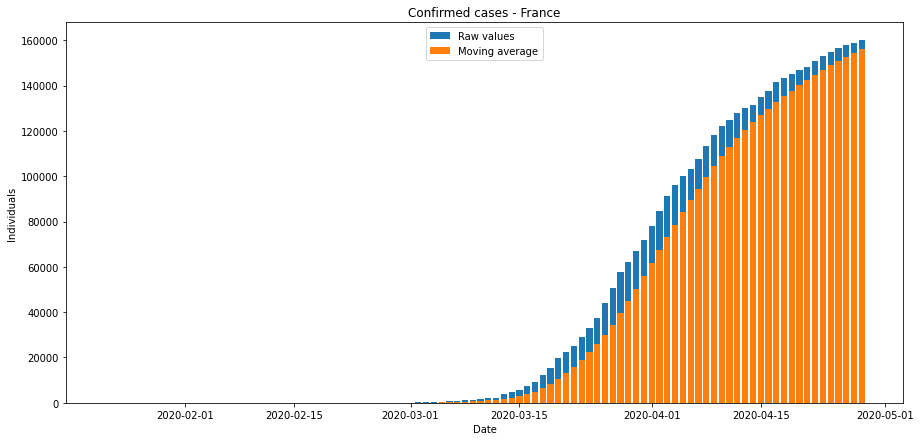

In [581]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 7)

plt.bar(list(map(datetime.date.fromtimestamp, confirmed_derivate_raw.index.values)), confirmed_cumulative_raw.values)
plt.bar(list(map(datetime.date.fromtimestamp, confirmed_derivate_raw.index.values)), confirmed_cumulative_moving_average.values)
plt.xlabel('Date')
plt.ylabel('Individuals')
plt.legend(['Raw values', 'Moving average'])
plt.title('Confirmed cases - France')

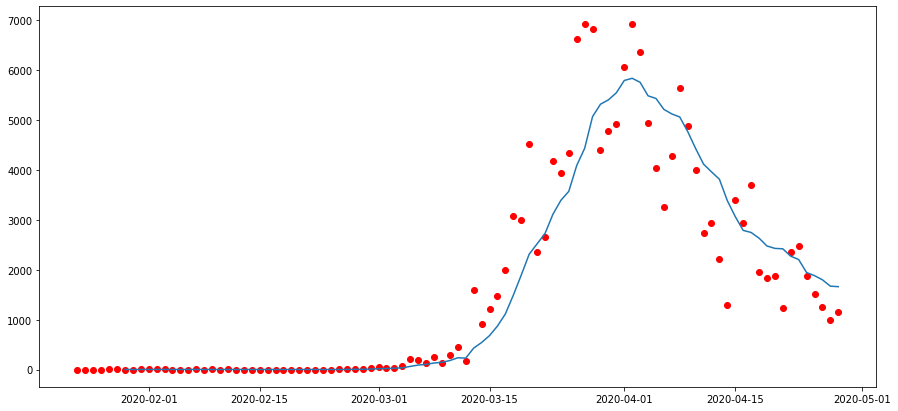

In [582]:
plt.scatter(list(map(datetime.date.fromtimestamp, confirmed_derivate_raw.index.values)), confirmed_derivate_raw.values, c='r')
plt.plot(list(map(datetime.date.fromtimestamp, confirmed_derivate_raw.index.values)), confirmed_derivate_moving_average.values)
plt.show()

### Derivate regression

Looks like a gaussian function:

[[ 1.30517837e+04 -5.52694777e-01 -1.92084032e+01]
 [-5.52694777e-01  7.71558605e-02  2.93300867e-03]
 [-1.92084032e+01  2.93300867e-03  8.21525032e-02]]


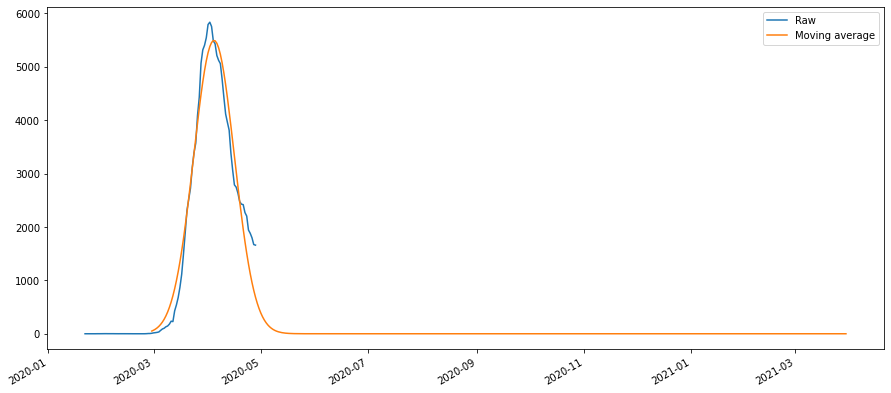

In [583]:
df = confirmed_derivate_moving_average.fillna(0)
x = list(map(datetime.date.fromtimestamp, df.index.values))
y = df.values

xs = np.where(y > 5)[0][0]
ydata = y[xs:]
xdata = np.arange(ydata.shape[0])

res, cov = gaussRegression(xdata, ydata)
print(cov)
forward_date = [(x[xs] + datetime.timedelta(days=i)) for i in range(len(res))]

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(x, y)
ax.plot(forward_date, res)
ax.legend(['Raw', 'Moving average'])
# plt.show()
plt.savefig('gaussian.png')

We can evaluate the theorical end of lockdown when 0 new cases are reported

In [584]:
zero_new_case = np.where(res[:res.shape[0] // 2] < 2)[0][0]
lockdown_end = forward_date[zero_new_case]
print(lockdown_end)

2020-05-21


27
0.9690089682109093


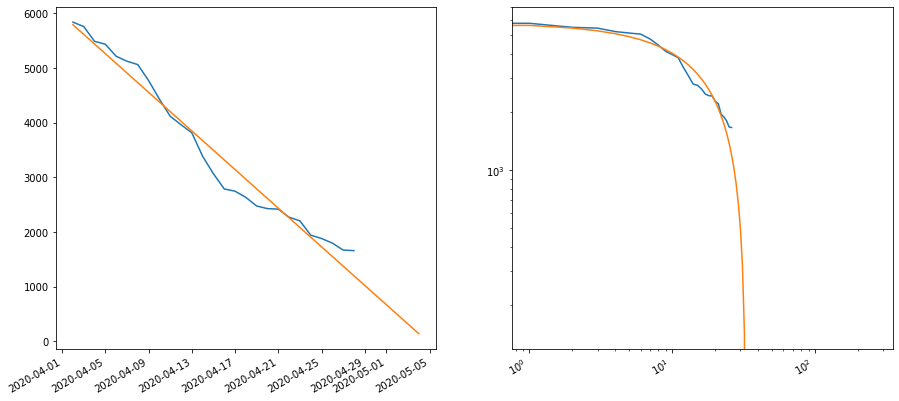

In [585]:
from sklearn.linear_model import LinearRegression

print(y.shape[0] - y.argmax())

X = np.array(range(y.shape[0] - y.argmax())).reshape(-1, 1)
Y = y[y.argmax():len(x)]

linearRegression = LinearRegression()
linearRegression.fit(X, Y)

print(linearRegression.score(X, Y))

forward = linearRegression.predict(np.arange(7 * 48 - y.argmax()).reshape(-1, 1))
end_forward = np.where(forward < 0)[0][0]

fig, axs = plt.subplots(ncols=2, nrows=1)
fig.autofmt_xdate()
axs[0].plot([(x[y.argmax()] + datetime.timedelta(days=i)) for i in range(len(Y))], Y, [(x[y.argmax()] + datetime.timedelta(days=i)) for i in range(end_forward)], forward[:end_forward])
axs[1].loglog(X, Y, forward)

In [586]:
zero_new_case = np.where(forward < 0)[0][0]
lockdown_end = forward_date[y.argmax() + zero_new_case]
print(lockdown_end)

2020-06-12


### Cumulative regression

This looks like a sigmoid curve:

/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-577-cc21d7bea473>:2: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x, A, B, k, x0: A / (1 + np.exp(-k*(x-x0)))+B


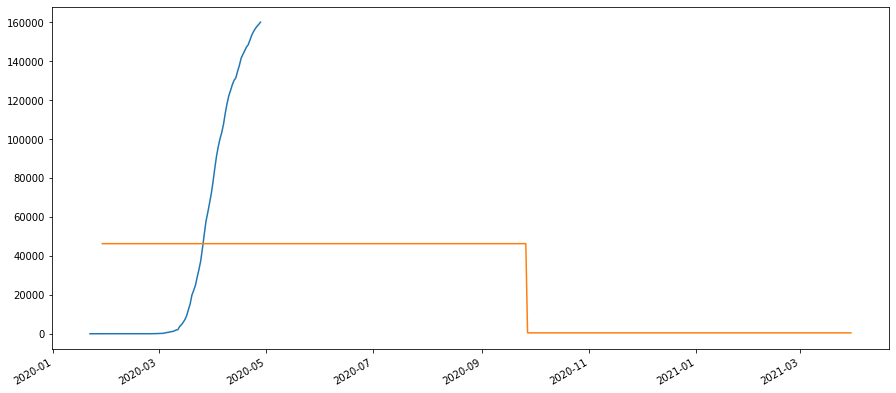

In [587]:
df = confirmed_cumulative_raw.fillna(0)
x = list(map(datetime.date.fromtimestamp, df.index.values))
y = df.values

xd = list(map(lambda x: x.days, np.array(x) - x[0]))

xs = np.where(np.array(xd) > 6)[0][0]
backward_lookup = 0
# xs = 20

xdata = xd[xs - backward_lookup:]
ydata = y[xs - backward_lookup:]

res, cov = logisticRegression(xdata, ydata)
forward_date = [(x[xs] + datetime.timedelta(days=i)) for i in range(len(res))]

fig, ax = plt.subplots()
fig.autofmt_xdate()
plt.plot(x, y)
plt.plot(forward_date, res)
plt.show()
# plt.savefig('sigmoid.png')

In [588]:
zero_new_case = np.where(np.diff(res[:res.shape[0] // 2]) < 1)[0][0]
lockdown_end = forward_date[zero_new_case]
print(lockdown_end)

2020-01-29


## Using a differential model to describe virus transmission

### SIR model

We use this three relationships to predict the pandemic expansion within a population:

\begin{align}
\frac{dS}{dt} &=-\frac{\beta SI}{N} \\
\frac{dI}{dt} &= \frac{\beta SI}{N}-\gamma I \\
\frac{dR}{dt} &= \gamma I
\end{align}

Our confirmed case are describe by the second equation, we assume $\beta = 0.2$ (which is the infection rate of the disease).
We compute $\gamma$ as the mean recovery/death rate.


In [589]:
@dataclass
class SARSCOV2:
    recovery_rate: float
    infection_rate: float
        
virus = SARSCOV2(
    recovery_rate  = all_countries.deaths.measurement.value.iloc[-1].sum() / all_countries.confirmed.measurement.value.iloc[-1].sum(),
    infection_rate = 0.22
)

print(f'Beta: {virus.infection_rate} | Gamma: {virus.recovery_rate}')

Beta: 0.22 | Gamma: 0.06971138172342277


Now we match this equations with actual data

In [590]:
from scipy.integrate import odeint

def SIR(y, t, virus_param):
    s, i, r = y
    beta, gamma = virus_param
    ds = - beta * s * i / (s + i + r)
    di = beta * s * i / (s + i + r) - gamma * i
    dr = gamma * i
    return [ds, di, dr]

def solve(t_range, init_cond, virus_param):
    t  = np.arange(*t_range, 1)
    return odeint(SIR, init_cond, t, args=(virus_param,)), t

We can test this model with some input parameters:
- $S_0$ = 997
- $I_0$ = 3
- $R_0$ = 0
- $\beta$ = 0.2
- $\gamma$ = COVID-19's recovery rate

Text(0.5, 1.0, 'SIR model with $S_0$=997, $I_0$=3, $R_0$=0')

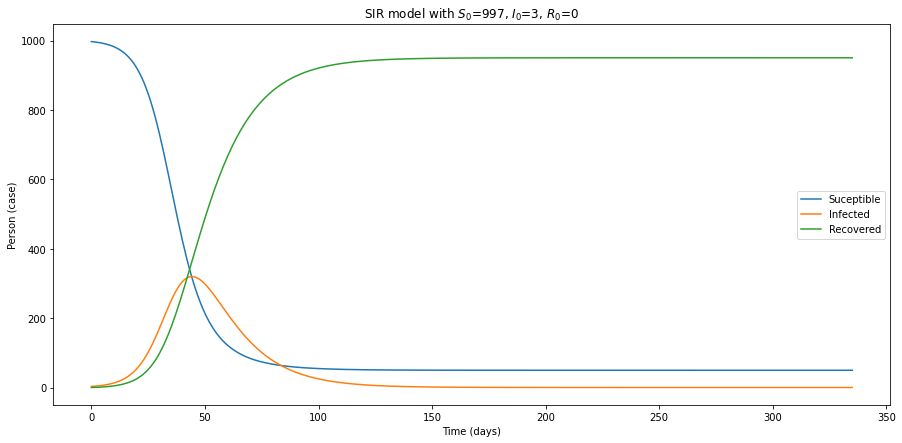

In [591]:
# Simple trial with N = 1000 -> (997 Suceptible, 3 infected, 0 recovered)
pandemic, t = solve((0, 7 * 48), [997, 3, 0], (virus.infection_rate, virus.recovery_rate))

fig, ax = plt.subplots()
ax.plot(t, pandemic[:, 0], t, pandemic[:, 1], t, pandemic[:, 2])
ax.legend(['Suceptible', 'Infected', 'Recovered'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Person (case)')
ax.set_title('SIR model with $S_0$=997, $I_0$=3, $R_0$=0')

We will now use least square to fit this SIR model on population

      fun: 1514032.8526321629
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.75208867e-01, -3.87560809e+04,  2.91038305e+00, -4.11242479e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 445
      nit: 52
   status: 0
  success: True
        x: array([1.26556025e+04, 2.11176983e-02, 0.00000000e+00, 3.13823997e-01])


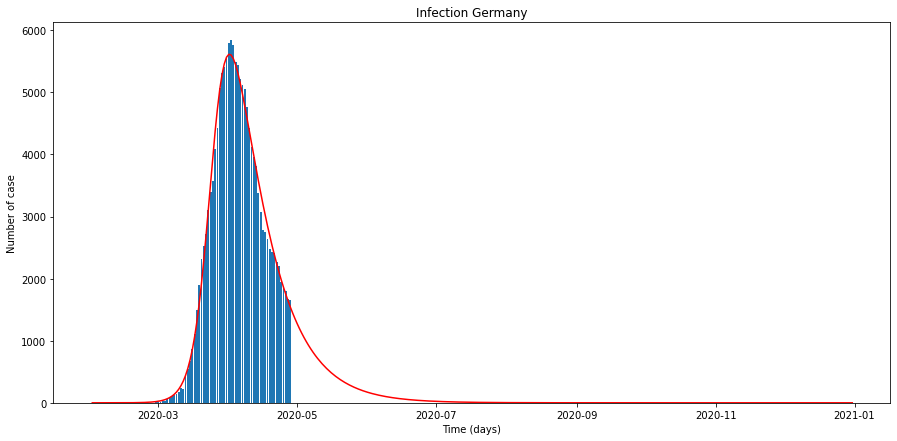

In [602]:
from scipy.optimize import minimize

df   = confirmed_derivate_moving_average.fillna(0)
x_df = list(map(datetime.date.fromtimestamp, df.index.values))
y_df = df.values

def optimize_sir(params, t_range, virus_params):
    global x_df, y_df
    y, beta = params[:3], params[3:]
    pandemic, _ = solve(t_range, y, (beta, virus_params))
    lq = lambda data, model: ((data - model[:, 1]) ** 2).sum()
    return lq(
        y_df[y_df.shape[0] - pandemic.shape[0]:],
        pandemic
    )

# Selection of first index
xs       = np.where(y_df > 1)[0][0]
i0       = y_df[first_index]
max_time = y_df[xs:].shape[0]

params = (
          (
              10000,               # S0
              i0,                  # I0
              0,                   # R0
              virus.infection_rate # Beta
          )
)
bounds = (
    (0, 50000), # S
    (0, 15),    # I
    (0,0),      # R
    (0, 0.5)    # Beta
)

result = minimize(
    optimize_sir,
    params,
    bounds=bounds,
    args=((0, max_time), (virus.recovery_rate)),
)
print(result)

# 48 weeks lookup
t            = np.arange(0, 7 * 48)
pandemic, t  = solve((t[0], t[-1]), result.x[:3], (result.x[3:], virus.recovery_rate))
forward_date = [(x[xs] + datetime.timedelta(days=i)) for i in range(pandemic.shape[0])]


fig, ax = plt.subplots()
ax.plot(forward_date, pandemic[:, 1], 'r')
ax.bar(forward_date[:len(x_df[xs:])], y_df[xs:])
ax.set_ylabel('Number of case')
ax.set_xlabel('Time (days)')
ax.set_title(f'Infection {country}')
fig.savefig('preditore.png')

In [618]:
zero_new_case = np.where(pandemic[:, 1] < 1)[0]
zero_new_case = zero_new_case[np.where(zero_new_case > 100)[0][0]]
lockdown_end = forward_date[zero_new_case - xs]
print(lockdown_end)

2020-08-08


### MLSim

The virus transmission model split individuals in categories:

- **Susceptible** of contracting the disease
- **Latent** which are already sick but do not express any symptoms
- **Quarantined** are placed to isolation before beeing tested
- **Confirmed** by medical test 

After tested positive to the virus, the patient could either recover from the disease or 

| Human   |  Virus  |
|---------|---------|
| Suceptib


Hence, we are able to describe each susceptibles, latents, quarantined and confirmed patient in time with this four relationships:

\begin{align}
\frac{dS}{dt} &= S(t) - \frac{\beta k_t S(t) L(t)}{N} \\
\frac{dL}{dt} &= L(t) - \frac{\beta k_t S(t) L(t)}{N} +  \frac{\beta k_t' S(t) L(t)}{N} + L_{in} (t) - L_{out} (t) - \sigma L(t) - L_{rm}(t) \\
\frac{dQ}{dt} &= Q(t) + \sigma I(t) - \gamma Q(t) - Q_{rm}(t) \\
\frac{dC}{dt} &= C(t) + \gamma Q(t) + Q_{rm} (t) - (\theta + \delta) \cdot C(t) - C_{rm} (t)
\end{align}

With:
- S: number of susceptible individuals.
- L: number of latent patients
- Q: number of quarantined patient
- C: number of confirmed patient
- $L_{in}$: number of inflowing patients. 
- $L_{out}$: number of outflowing patients.
- $Q_{rm}$: the last number in the $Q$ list
- $C_{rm}$: the last number in the $C$ list.
- $\beta$: Infection rate
- $k_t$: average contacts in the region
- $k_t'$: average contacts across the regions
- $\sigma$: quarantine rate per person per day
- $\gamma$: diagnostic rate per person per day
- $\theta$: recovery rate
- $\delta$: mortality rate